# Implementing a Neural Network using Numpy

In this, we will implement a simple 3-layer neural network from scratch. 

In [8]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from helpr import * 

# Display plots inline and change default figure size
%matplotlib inline

## Generating a dataset

Let's start by generating a dataset. Fortunately, [scikit-learn](http://scikit-learn.org/) has some useful dataset generators. Will use [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

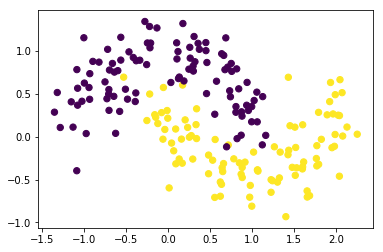

In [9]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y)

The generated dataset has two classes, plotted as violet and yellow points. It can be considered as the dataset of hospital patients where; violet dots represent male patients and the yellow dots are female patients, with the x- and y- axis being medical measurements. 

The goal is to train a **Machine Learning classifier** that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes.

## Logistic Regression

First, let's train a **Logistic Regression** classifier provided by `scikit-learn` library. It's input will be the x- and y-values and the output the predicted class (0 or 1).

In [10]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy of logistic regression: 84 % (percentage of correctly labelled datapoints)


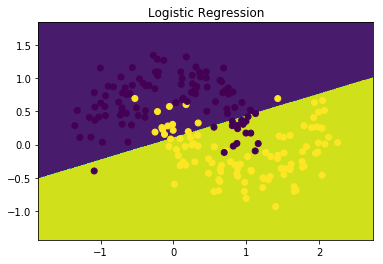

In [13]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x),X,y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X)
print ('Accuracy of logistic regression: %d ' % float((np.dot(y.T,LR_predictions) + np.dot(1-y.T,1-LR_predictions))/float(y.T.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

The graph shows the decision boundary learned by the Logistic Regression. It separates the data but unable to capture the "moon shape" of the dataset.

## Training a Neural Network (Vectorized Implementation)

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. 

The network looks something like this:

<img src='./nn-3-layer-network.png' style='width: 50%'/>

where nodes in each layer is somewhat like (except the input layer):
<img src="nodeImg.png" style="width:20%">

In implementation, the network will have following architecture:

Activation function for hidden layer: tanh (optional: sigmoid, Relu)

Activation function for output layer: softmax

The number of nodes in the input layer: 2 (dimensionality of our data). 

The number of nodes in the output layer: 2 (number of classes). 

The number of nodes in the hidden layer: 5 (more nodes: complex functions can be learned).

### Forward propagation: Predication Step

Our network makes predictions using *forward propagation*. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

where, $W_1$, and $W_2$ are of dimension 2X5 and 5X2 respectively, $b_1$ and $b_2$ are of 1X5 and 1X2 respectively. The softmax function for $n$ classes (or output nodes) is defined as:

$$
\begin{aligned}
{\displaystyle Softmax (z) = {\frac {e^{z^{j}}}{\sum _{j=1}^{n}e^{z^{j}}}}}  
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. 

$W_1, b_1, W_2, b_2$ are  parameters of the network, which we need to learn from our training data.  

### Loss Function: log loss

Error function (loss function): log loss.

If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$





That is, sum over all training examples and add to the loss if incorrect class is predicted. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

### Back propagation: Learning the Parameters

Finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. 

To find values of parameters that minimize the loss function, **Gradient descent method** with a fixed learning rate is used. 

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="sgd.gif" style="width:400;height:400;"> <img src="sgd_bad.gif" style="width:400;height:400;">

To implement gradient descent method, gradients of the loss function w.r.t. the parameters are needed: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$.



$$
\begin{aligned}
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
& where, \\
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\ 
& \ or \\
& \delta_2 = (1 - a_1^2) \circ \delta_3W_2^T \\
\end{aligned}
$$

### Implementation:

In [22]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (Fixed values, can be changed)
epsilon = 0.01 # learning rate for gradient descent

Function to train the Neural Network.

In [23]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - epochs: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, epochs=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent.
    for i in range(0, epochs):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 

        # Backpropagation
        delta3 = a2
        delta3[range(num_examples), y] -= 1 
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True) 
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

**loss function** implementation:

In [24]:
# Function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(a2[range(num_examples), y]) 
    data_loss = np.sum(corect_logprobs)
    return 1./num_examples * data_loss

### A network with a hidden layer of size 3

In [25]:
# Build a model with a 5-dimensional hidden layer
model = build_model(5, print_loss=True)

Loss after iteration 0: 0.395338
Loss after iteration 1000: 0.065563
Loss after iteration 2000: 0.067940
Loss after iteration 3000: 0.067744
Loss after iteration 4000: 0.067631
Loss after iteration 5000: 0.067571
Loss after iteration 6000: 0.067533
Loss after iteration 7000: 0.067508
Loss after iteration 8000: 0.067489
Loss after iteration 9000: 0.067475
Loss after iteration 10000: 0.067463
Loss after iteration 11000: 0.067454
Loss after iteration 12000: 0.067446
Loss after iteration 13000: 0.067439
Loss after iteration 14000: 0.067434
Loss after iteration 15000: 0.067429
Loss after iteration 16000: 0.067424
Loss after iteration 17000: 0.067421
Loss after iteration 18000: 0.067418
Loss after iteration 19000: 0.067415


To **predict** the class, use forward propagation as defined above and returns the class with the highest probability.

In [26]:
# Function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(a2, axis=1)

In [27]:
# Print accuracy
predictions = predict(model, X)
print ('Accuracy: %d' % float((np.dot(y,predictions) + np.dot(1-y,1-predictions))/float(y.size)*100) + '%')

Accuracy: 97%


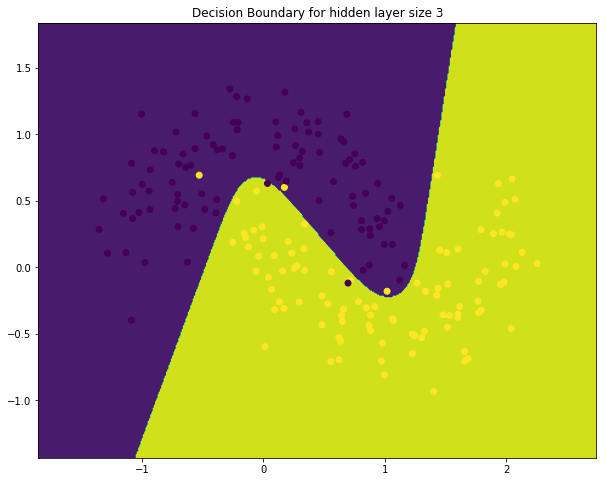

In [28]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x),X,y)
plt.title("Decision Boundary for hidden layer size 3")

Yay! This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

# Varying the hidden layer size [optional]

Instead of 3 as the hidden layer size, vary the hidden layer size and see the affect on network output


In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x),X,y)
plt.show()

Hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting. 